In [1]:
project_name = '06b-anime-dcgan'

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: osiomheleogwanighie
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:01<00:00, 272MB/s]


In [35]:
import os

data_dir = './animefacedataset'
print(os.listdir(data_dir))

['images']


In [36]:
print(os.listdir(data_dir +'/images')[:10])

['49702_2015.jpg', '36821_2012.jpg', '39640_2012.jpg', '47397_2014.jpg', '47624_2014.jpg', '62263_2019.jpg', '12300_2005.jpg', '15181_2006.jpg', '3471_2002.jpg', '37483_2012.jpg']


In [37]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [38]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [39]:
train_ds = ImageFolder(data_dir, transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
    ]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [40]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [42]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

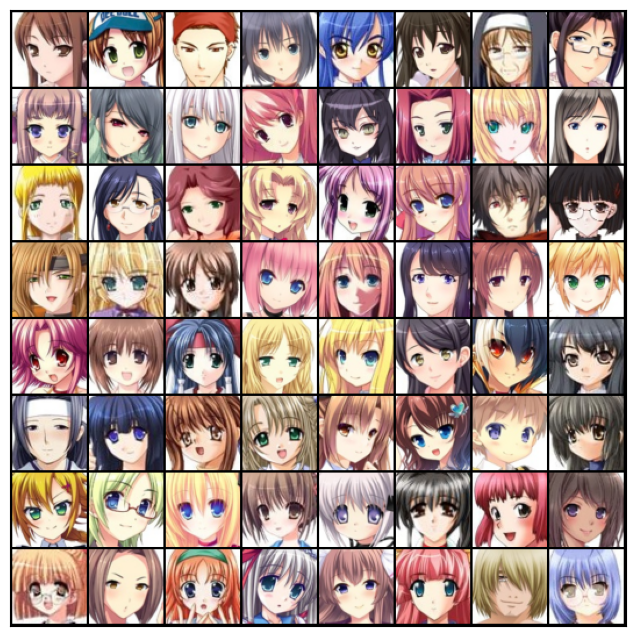

In [43]:
show_batch(train_dl)

In [44]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [45]:
device = get_default_device()
print(device)

cuda


In [46]:
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator Model

In [47]:
import torch.nn as nn

In [48]:
discriminator = nn.Sequential(
    # input is 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid())

In [49]:
discriminator = to_device(discriminator, device)

# Generator model

In [50]:
latent_size = 128

In [51]:
generator = nn.Sequential(
    # input: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # state size. 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # state size. 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # state size. 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # state size. 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # state size. 3 x 64 x 64
    )

torch.Size([128, 3, 64, 64])


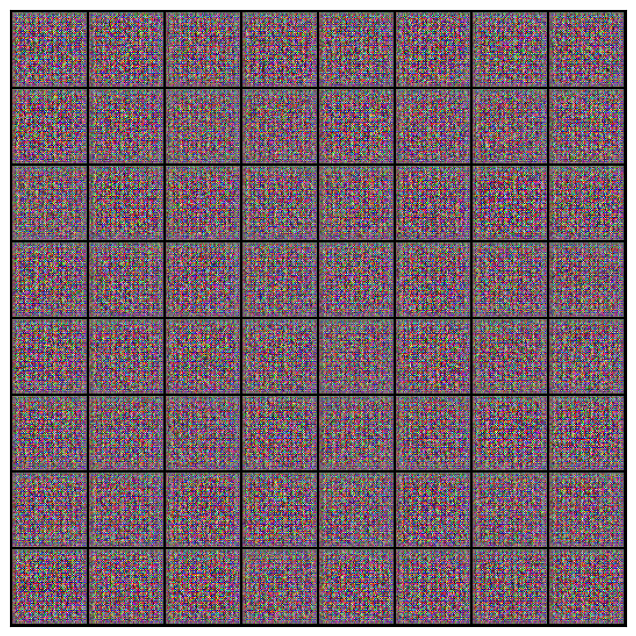

In [52]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [53]:
generator = to_device(generator, device)

# Discriminator Training

In [54]:
def train_discriminator(real_images, optimizer):
    # Clear discriminator gradients
    optimizer.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)

    # Calculate loss on all-real batch
    real_targets = torch.ones(real_images.size(0), 1).to(device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = real_preds.mean().item()

    # Generate fake images
    latent = torch.randn(real_images.size(0), latent_size, 1, 1).to(device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(real_images.size(0), 1).to(device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = fake_preds.mean().item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    optimizer.step()
    return loss.item(), real_score, fake_score

# Generator Training

In [55]:
def train_generator(optimizer):
    # Clear generator gradients
    optimizer.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1).to(device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1).to(device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    optimizer.step()
    return loss.item()

In [56]:
from torchvision.utils import save_image

In [57]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [58]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated/fake_images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), fake_fname, nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu(), nrow=8).permute(1, 2, 0))

In [59]:
fixed_latent = torch.randn(64, latent_size, 1, 1).to(device)

Saving generated/fake_images-0000.png


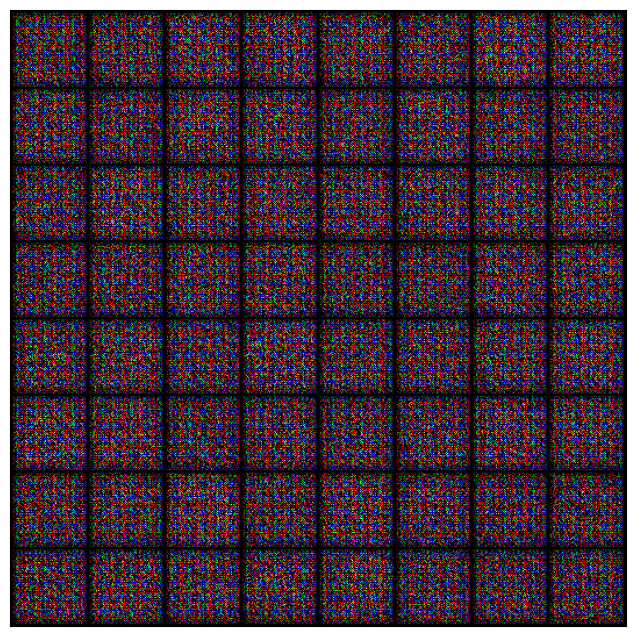

In [60]:
save_samples(0, fixed_latent)

# Full training loop

In [61]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [69]:
def fit(epochs, lr, start_idx=11):

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    optim_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    optim_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train Discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, optim_d)
            # Train Generator
            loss_g = train_generator(optim_g)
            loss_g = train_generator(optim_g)

        # Record losses and scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

         # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [70]:
lr = 0.0002
epochs = 15

In [71]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/15], loss_g: 1.8920, loss_d: 0.2002, real_score: 0.8933, fake_score: 0.0399
Saving generated/fake_images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/15], loss_g: 3.4147, loss_d: 0.7896, real_score: 0.6057, fake_score: 0.0042
Saving generated/fake_images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/15], loss_g: 4.9816, loss_d: 0.2482, real_score: 0.8537, fake_score: 0.0200
Saving generated/fake_images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/15], loss_g: 7.4553, loss_d: 1.4874, real_score: 0.3411, fake_score: 0.0002
Saving generated/fake_images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/15], loss_g: 9.7442, loss_d: 0.6760, real_score: 0.6316, fake_score: 0.0004
Saving generated/fake_images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/15], loss_g: 2.0045, loss_d: 0.1566, real_score: 0.9102, fake_score: 0.0287
Saving generated/fake_images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/15], loss_g: 4.1320, loss_d: 0.4061, real_score: 0.8498, fake_score: 0.1574
Saving generated/fake_images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/15], loss_g: 10.4005, loss_d: 0.8521, real_score: 0.9774, fake_score: 0.3825
Saving generated/fake_images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/15], loss_g: 11.6304, loss_d: 0.8030, real_score: 0.9987, fake_score: 0.4852
Saving generated/fake_images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/15], loss_g: 6.1592, loss_d: 0.2763, real_score: 0.8597, fake_score: 0.0026
Saving generated/fake_images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/15], loss_g: 7.4365, loss_d: 0.1037, real_score: 0.9210, fake_score: 0.0018
Saving generated/fake_images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/15], loss_g: 4.8569, loss_d: 0.3438, real_score: 0.8768, fake_score: 0.1569
Saving generated/fake_images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/15], loss_g: 7.1732, loss_d: 0.3940, real_score: 0.9373, fake_score: 0.2657
Saving generated/fake_images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/15], loss_g: 3.3675, loss_d: 0.0543, real_score: 0.9697, fake_score: 0.0198
Saving generated/fake_images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/15], loss_g: 1.5246, loss_d: 0.3856, real_score: 0.7920, fake_score: 0.0162
Saving generated/fake_images-0025.png


In [72]:
from IPython.display import Image

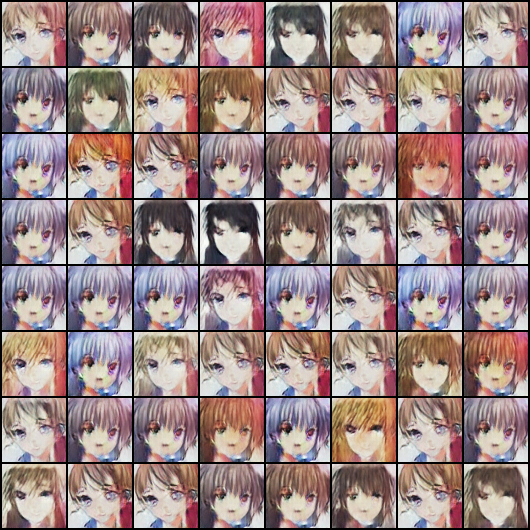

In [73]:
Image("/content/generated/fake_images-0025.png")

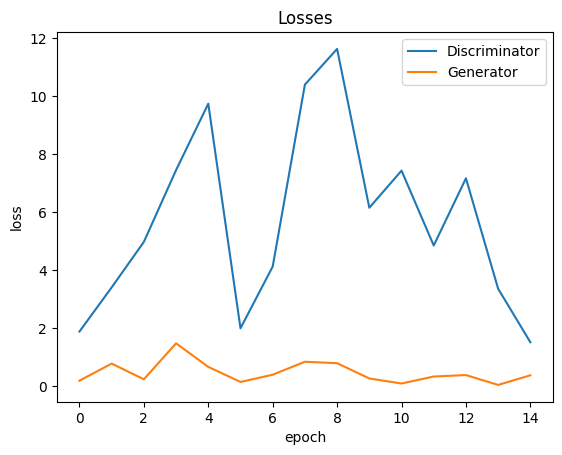

In [75]:
losses_d = history[0]
losses_g = history[1]

plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

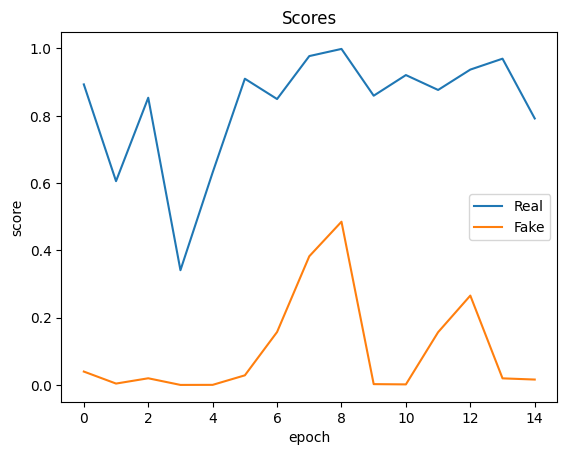

In [76]:
real_scores = history[2]
fake_scores = history[3]

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');